## Bike Sharing Problem - Generalized Linear Modeling

In [52]:
## Loading required package
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from warnings import filterwarnings
filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import scipy.stats as stats

# Sklearn metrics
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.metrics import mean_absolute_error, median_absolute_error
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

# Sklearn models
from sklearn.linear_model import Lasso, ElasticNet, Ridge, SGDRegressor, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

# Sklearn untility functions
from sklearn.model_selection import train_test_split

# XGBoost, Catboost, and LightGBM models
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostRegressor
import lightgbm as lgbm

# Beautify evaluation tables
from prettytable import PrettyTable

# Bayesian Optimization
from bayes_opt import BayesianOptimization
from bayes_opt.observer import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs

from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_evaluations
from skopt.plots import plot_objective
from skopt.plots import plot_convergence

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

np.random.seed(42)

In [2]:
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

# Cluster Inspection
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_231"; Java(TM) SE Runtime Environment (build 1.8.0_231-b11); Java HotSpot(TM) 64-Bit Server VM (build 25.231-b11, mixed mode)
  Starting server from /Users/chrisjcc/virtualenvs/ml/lib/python2.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/wx/2nnnpz4x1d12_15l55htrrbh0000gn/T/tmpXNTz4Q
  JVM stdout: /var/folders/wx/2nnnpz4x1d12_15l55htrrbh0000gn/T/tmpXNTz4Q/h2o_chrisjcc_started_from_python.out
  JVM stderr: /var/folders/wx/2nnnpz4x1d12_15l55htrrbh0000gn/T/tmpXNTz4Q/h2o_chrisjcc_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Berlin
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.9
H2O cluster version age:,1 month and 19 days
H2O cluster name:,H2O_from_python_chrisjcc_bzmk2p
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [3]:
# File path 
base_dir = '/Users/chrisjcc/Downloads/'

data_path = base_dir + 'hour.csv'
# Load data
#data = pd.read_csv(data_path) 

In [4]:
# Load data
#data = h2o.import_file(data_path)
data = h2o.upload_file(data_path, destination_frame="train_frame")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [5]:
# Quick check of proper loading of dataset
data.head()

instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
1,2011-01-01 00:00:00,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0,3,13,16
2,2011-01-01 00:00:00,1,0,1,1,0,6,0,1,0.22,0.2727,0.8,0,8,32,40
3,2011-01-01 00:00:00,1,0,1,2,0,6,0,1,0.22,0.2727,0.8,0,5,27,32
4,2011-01-01 00:00:00,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0,3,10,13
5,2011-01-01 00:00:00,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0,0,1,1
6,2011-01-01 00:00:00,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
7,2011-01-01 00:00:00,1,0,1,6,0,6,0,1,0.22,0.2727,0.8,0,2,0,2
8,2011-01-01 00:00:00,1,0,1,7,0,6,0,1,0.2,0.2576,0.86,0,1,2,3
9,2011-01-01 00:00:00,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0,1,7,8
10,2011-01-01 00:00:00,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0,8,6,14


In [6]:
data.summary()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
type,int,time,int,int,int,int,int,int,int,int,real,real,real,real,int,int,int
mins,1.0,1.29384e+12,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.02,0.0,0.0,0.0,0.0,0.0,1.0
mean,8690.0,1.32547731455e+12,2.50163991024,0.502560561597,6.53777547615,11.5467518269,0.0287703550262,3.00368260544,0.682720524771,1.425283388,0.496987168422,0.475775102135,0.627228839404,0.190097606306,35.6762184245,153.78686921,189.463087635
maxs,17379.0,1.356912e+12,4.0,1.0,12.0,23.0,1.0,6.0,1.0,4.0,1.0,1.0,1.0,0.8507,367.0,886.0,977.0
sigma,5017.02949961,18150225217.8,1.10691813945,0.500007829091,3.43877571375,6.91440509526,0.167165276384,2.00577145611,0.465430633524,0.639356877754,0.19255612125,0.171850215635,0.192929834063,0.122340228573,49.3050303871,151.357285913,181.387599092
zeros,0,0,0,8645,0,726,16879,2502,5514,0,0,2,22,2180,1581,24,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1.0,2011-01-01 00:00:00,1.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0,3.0,13.0,16.0
1,2.0,2011-01-01 00:00:00,1.0,0.0,1.0,1.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.8,0.0,8.0,32.0,40.0
2,3.0,2011-01-01 00:00:00,1.0,0.0,1.0,2.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.8,0.0,5.0,27.0,32.0


In [ ]:
# Preprocessing: Renaming columns names to more readable names
#data.rename(columns={'instant':'rec_id',
#                     'dteday':'datetime',
#                     'holiday':'is_holiday',
#                     'workingday':'is_workingday',
#                     'weathersit':'weather_condition',
#                     'hum':'humidity',
#                     'mnth':'month',
#                     'hr':'hour',
#                     'cnt':'total_count',
#                     'yr':'year', # remove
#                    },
#            #inplace=True
#           )

In [159]:
print(data.names)

[u'rec_id', u'datetime', u'season', u'year', u'month', u'hour', u'is_holiday', u'weekday', u'is_workingday', u'weather_condition', u'temp', u'atemp', u'humidity', u'windspeed', u'casual', u'registered', u'total_count']


In [8]:
data.set_names(['rec_id','datetime', 'season', 'year', 'month', 'hour', 'is_holiday', 
                'weekday', 'is_workingday', 'weather_condition', 'temp', 'atemp', 'humidity', 
                'windspeed', 'casual', 'registered', 'total_count'])

rec_id,datetime,season,year,month,hour,is_holiday,weekday,is_workingday,weather_condition,temp,atemp,humidity,windspeed,casual,registered,total_count
1,2011-01-01 00:00:00,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0,3,13,16
2,2011-01-01 00:00:00,1,0,1,1,0,6,0,1,0.22,0.2727,0.8,0,8,32,40
3,2011-01-01 00:00:00,1,0,1,2,0,6,0,1,0.22,0.2727,0.8,0,5,27,32
4,2011-01-01 00:00:00,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0,3,10,13
5,2011-01-01 00:00:00,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0,0,1,1
6,2011-01-01 00:00:00,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
7,2011-01-01 00:00:00,1,0,1,6,0,6,0,1,0.22,0.2727,0.8,0,2,0,2
8,2011-01-01 00:00:00,1,0,1,7,0,6,0,1,0.2,0.2576,0.86,0,1,2,3
9,2011-01-01 00:00:00,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0,1,7,8
10,2011-01-01 00:00:00,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0,8,6,14


Divide the dataset into training and testing sets (randomly and stratified).

In [9]:
# Split the data into Train/Test/Validation with Train having 70% and test and validation 15% each
train, test, valid = data.split_frame(ratios=[.7, .15], 
                                      destination_frames=['train', 'test', 'valid'])

In [10]:
# Setting proper data types (i.e.categorical fetures)

# convert response column to a factor
train["season"].asfactor()

# date time conversion
pattern = "%m/%d/%Y %I:%M:%S %p"
train.as_date(pattern)

train['season'].asfactor()
train['is_holiday'].asfactor()
train['weekday'].asfactor()
train['weather_condition'].asfactor()
train['is_workingday'].asfactor()
train['month'].asfactor()
train['hour'].asfactor()
train['year'].asfactor()

year
0
0
0
0
0
0
0
0
0
0


In [11]:
predictors = ["season", "is_holiday", "weekday", "weather_condition", 
              "is_workingday", "month", "hour"]
response_col = "total_count"

In [12]:
print("We have %d training samples and %d test samples." % (train['total_count'].dim[0], 
                                                            test['total_count'].dim[0]))

We have 12146 training samples and 2630 test samples.


In [13]:
# Encoding all the categorical features
cat_attr_list = ['season','is_holiday',
                 'weather_condition','is_workingday',
                 'hour','weekday','month',#'year'
                ]

# though we have transformed all categoricals into their one-hot encodings, note that ordinal
# attributes such as hour, weekday, and so on do not require such encoding.
numeric_feature_cols = ['temp','humidity','windspeed', 'atemp',
                        'hour','weekday','month',#'year'
                       ]
subset_cat_features =  ['season','is_holiday','weather_condition','is_workingday']

In [14]:
# Generate a GLM model using the training dataset
glm_model = H2OGeneralizedLinearEstimator(family = "poisson", #"gaussian"
                                          #use_all_factor_levels_flag = True,
                                          solver='IRLSM', # Iteratively Reweighted Least Squares Method, and L_BFGS: Limited-memory Broyden-Fletcher-Goldfarb-Shanno algorithm
                                          lambda_ = 0, 
                                          nfolds = 3,
                                          fold_assignment = "stratified",
                                          compute_p_values = True
                                          #validation_frame = valid
                                         )

In [15]:
glm_model.train(x=predictors, y=response_col, training_frame=train)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [16]:
# Coefficients that can be applied to the non-standardized data.
print(glm_model.coef())

{u'hour': 0.05573218996791075, u'season': 0.24561398025858946, u'is_workingday': 0.04707691474173261, u'month': -0.034528386869351425, u'is_holiday': -0.15755668791115818, u'Intercept': 4.384787013435053, u'weather_condition': -0.23497454175911667, u'weekday': 0.014005827075447388}


In [17]:
# Coefficients fitted on the standardized data (requires standardize = True, which is on by default)
print(glm_model.coef_norm())

{u'hour': 0.38525681302662024, u'season': 0.2721008702694859, u'is_workingday': 0.021925463333274393, u'month': -0.11880896172908753, u'is_holiday': -0.026395140347488286, u'Intercept': 5.1520556356857545, u'weather_condition': -0.15079149835087968, u'weekday': 0.028157842683230225}


In [18]:
# Print the Coefficients table
glm_model._model_json['output']['coefficients_table']


Coefficients: glm coefficients


,names,coefficients,std_error,z_value,p_value,standardized_coefficients
0,Intercept,4.384787,0.003092,1418.051497,0.0,5.152056
1,season,0.245614,0.001302,188.703231,0.0,0.272101
2,month,-0.034528,0.000423,-81.574303,0.0,-0.118809
3,hour,0.055732,0.000099,562.005658,0.0,0.385257
4,is_holiday,-0.157557,0.004493,-35.067371,0.0,-0.026395
5,weekday,0.014006,0.000330,42.419079,0.0,0.028158
6,is_workingday,0.047077,0.001466,32.112510,0.0,0.021925
7,weather_condition,-0.234975,0.001127,-208.565245,0.0,-0.150791


In [19]:
# Print the Standard error
print(glm_model._model_json['output']['coefficients_table']['std_error'])

[0.0030921211415158197, 0.001301588630758296, 0.0004232752889190196, 9.916659952064865e-05, 0.004492971225501657, 0.00033017754143117384, 0.001465999234278495, 0.001126623669421556]


In [20]:
# Print the p values
print(glm_model._model_json['output']['coefficients_table']['p_value'])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [21]:
# Print the z values
print(glm_model._model_json['output']['coefficients_table']['z_value'])

[1418.0514969363533, 188.703231154913, -81.57430346933705, 562.0056575228849, -35.067370789486056, 42.4190785803853, 32.11250977556066, -208.56524510954043]


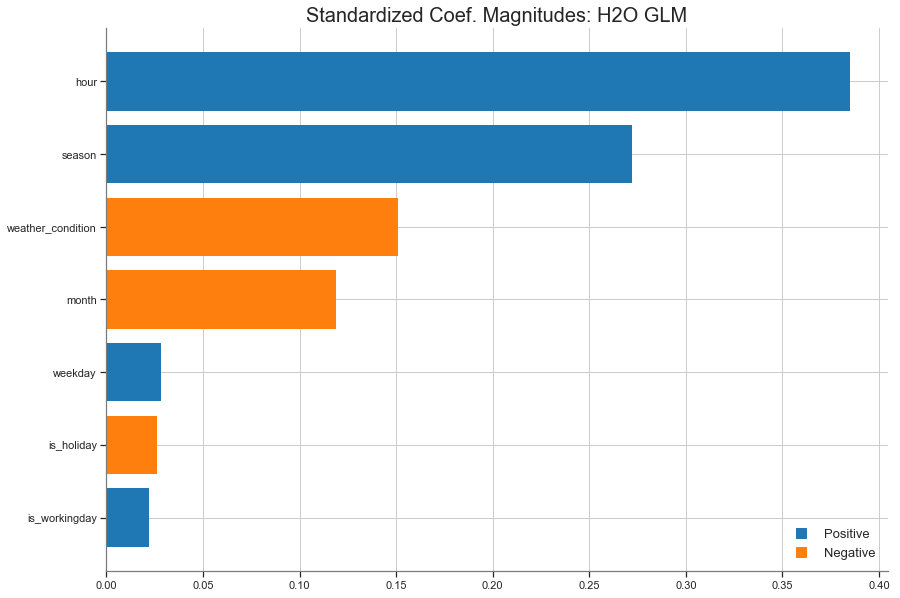

In [22]:
# Retrieve a graphical plot of the standardized coefficient magnitudes
glm_model.std_coef_plot()

In [23]:
# Predict using the GLM model and the testing dataset
predict = glm_model.predict(test)

# View a summary of the prediction
predict.head()

glm prediction progress: |████████████████████████████████████████████████| 100%


predict,StdErr
85.1942,0.00242518
100.698,0.00226547
119.024,0.00213547
125.846,0.00209973
133.059,0.00206813
155.391,0.00211243
242.693,0.00229367
61.925,0.00255043
168.866,0.00216967
238.78,0.00208594


In [24]:
bc = h2o.H2OFrame([("Intercept",-1000,1000,3,30)], 
                  column_names=["names","lower_bounds","upper_bounds","beta_given","rho"])

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [25]:
# Model selection
models = [
    # specify the hyper-parameters 
    # Generate a GLM model using the training dataset
    H2OGeneralizedLinearEstimator(family = "poisson", #"gaussian"
                                  #use_all_factor_levels_flag = True,
                                  solver= 'l_bfgs', # 'irlsm' Iteratively Reweighted Least Squares Method, and l_bfgs: Limited-memory Broyden-Fletcher-Goldfarb-Shanno algorithm
                                  lambda_ = 1e-5, 
                                  alpha = 1, # 1 - LASSO,  0 - Ridge regression
                                  nfolds = 3,
                                  fold_assignment = 'stratified',
                                  #compute_p_values = True, # only with 'irlsm' solver
                                  validation_frame = valid,
                                  lambda_search = True,
                                  beta_constraints=bc,
                                  standardize=True,
                                  )
]

In [26]:
table = PrettyTable()
table.field_names = ["Model", "Dataset", 
                     "MAE", 
                     #"MSE",
                     #"Variance"
                    ]

In [27]:
#%%time
for model in models:
    dataset = 'training'
    
    # Model training
    model.train(x=predictors, y=response_col, training_frame=train)
    
    # Make prediction on test and training data set
    y_pred = model.predict(test)
    y_res  = model.predict(train)
    
    #print(test[response_col].as_data_frame().as_matrix())
    #print(y_pred['predict'].as_data_frame().as_matrix())
    
    #print(test[response_col].shape)
    #print(y_pred['predict'].shape)
    
    # Evaluate model performance (for shortness of time will only CV MAE)
    mae = mean_absolute_error(test[response_col].as_data_frame(),
                              y_pred['predict'].as_data_frame()
                             )
    
    # Cross-Validated Mean Absolute Deviation regression loss
    #mae = -np.mean(cross_val_score(model, 
    #                               train[predictors].as_data_frame(),
    #                               train[response_col].as_data_frame(), 
    #                               cv=3, n_jobs=-1, 
    #                               scoring="neg_mean_absolute_error"))

    #mae = model.mae(xval=True)
    
    #variance  = abs(mean_absolute_error(train[response_col].as_data_frame(),
    #                                    y_res) - mae
    #               )
    
    #print("%.2f" % mean_absolute_error(train[response_col].as_data_frame(),
    #                                   y_res
    #                                  )
    #     )
 
    table.add_row([type(model).__name__, 
                   dataset,
                   format(mae, '.2f'),
                   #format(mse, '.2f'),   
                   #format(variance, '.2f')
                  ],
                 )
    
print(table)

glm Model Build progress: |███████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
+-------------------------------+----------+--------+
|             Model             | Dataset  |  MAE   |
+-------------------------------+----------+--------+
| H2OGeneralizedLinearEstimator | training | 120.22 |
+-------------------------------+----------+--------+


In [28]:
models[0].coef()

{u'Intercept': 3.769616084377265,
 u'hour': 0.07564578548707833,
 u'is_holiday': -0.2639534552727617,
 u'is_workingday': 0.07168927155020803,
 u'month': 0.01380731568076803,
 u'season': 0.1584587694289864,
 u'weather_condition': -0.325648166426235,
 u'weekday': 0.01781221385762686}

glm prediction progress: |████████████████████████████████████████████████| 100%


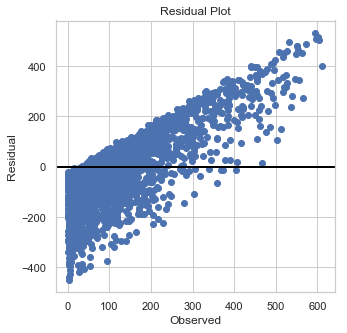

In [29]:
# Analysing Residuals in model's predictinos
predicted = model.predict(test)

fig,ax = plt.subplots(figsize=(5,5))
ax.scatter(train.as_data_frame()[response_col], 
           train.as_data_frame()[response_col] -  predicted.as_data_frame()['predict'])
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
ax.set_title('Residual Plot')
plt.show()

## Deep Learning

In [154]:
# Simple Deep Learning - Predict Arrest
model_dl = H2ODeepLearningEstimator(distribution="poisson", #"gaussian", 
                                    variable_importances=True,
                                    categorical_encoding='one_hot_internal',
                                    loss="Automatic",
                                    activation = "rectifier", 
                                    hidden = [150, 150, 150], 
                                    epochs = 64
                                   )

model_dl.train(x=predictors, 
               y=response_col,
               training_frame   =train,
               #validation_frame=valid
              )

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [155]:
# Make prediction on test and training data set
y_pred = model_dl.predict(test)
y_res  = model_dl.predict(train)

deeplearning prediction progress: |███████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%


In [156]:
# Evaluate model performance (for shortness of time will only CV MAE)
mae = mean_absolute_error(test[response_col].as_data_frame(), 
                         y_pred['predict'].as_data_frame()
                        )
#mae = model_dl.mae(xval=True)

In [157]:
table = PrettyTable()
table.field_names = ["Model", 
                     "Dataset", 
                     "MAE", 
                     #"MSE",
                     #"Variance"
                    ]

In [158]:
table.add_row(['H2ODeepLearningEstimator', 
               'training',
               format(mae, '.2f'),
               ],
              )
print(table)
#H2ODeepLearningEstimator

+--------------------------+----------+-------+
|          Model           | Dataset  |  MAE  |
+--------------------------+----------+-------+
| H2ODeepLearningEstimator | training | 69.27 |
+--------------------------+----------+-------+
